# Filter questions

Up till now, we've been modelling the amp like this:

<img src="resources/patch-comp-6-full.png" style="margin:auto" />

## 1. If we include all filters, is there a "response time of the summing amp"?

In our model, the summing amplifier represented by $\Sigma$ has been given a "speed" in a manner equivalent to placing a 1-pole filter at its output.
As far as I can work out, there is no mention of this finite speed in Sigworth or Weerakoon or other sources.
But it could be a useful approximation that combines (1) the omitted time constant of Rs compensation, (2) the omitted stimulus filter.

IF it filters Vc too, THEN we can see this by changing the Rs comp speed (see below).

## 2. If we include all filters, will be we able to match simple steps _perfectly_?

Up until now, we've been (very) interested in the mid-time phenomenena, e.g. the rise time due to $C_m$ with different levels of $R_s$ compensation and prediction.
Various things have stopped us from looking at the faster times (e.g. < 1ms), including known omissions (e.g. the filters, the op-amp bandwidth correction, Cfast with 2 taus) and the Cfast correction being very sensitive (sum of two large exponentials with almost-equal opposing magnitudes).
_If_ we keep everything very simple (no Rs comp/pred, model cell, large V steps), can we fit the basic model more exactly? If so, this would let us check $R_f$ and $C_f$ or at least $\tau_f=R_f C_f$.

Adding in filter1, filter2, and the stimulus filter, our schematic looks like this:

<img src="resources/patch-comp-8-filters-NEW.png" style="margin:auto" />

where Fs is the stimulus filter and F1,F2 are filters 1 and 2.

Note that filter1 and the stimulus filter are essential: Fs changes the voltage steps, and F1 changes the voltage "seen" by series resistance compensation. Filter1 is always on, but has settings that can be changed. Filter2 can be switched off.

## 3. What does `r_series_tau` do, exactly?

The hardware papers and chapter don't mention it.
The manuals do but don't explain.
The _Axon_ guide and manuals mention they use a "lag" which corresponds to $1/(2\pi f)$ of a 1-pole filter placed in the Rs comp feedback loop.

So a sensible guess would be that `r_series_tau` pertains to a filter in the Rs comp loop. But we can see from the schematics that F1 is also in that loop. And Patchmaster will adjust filter1 settings if `r_series_tau` is changed:

| `r_series_tau` | Filter 1      | $1/(2\pi f)$ |
|----------------|---------------|--------------|
| 2 us           | HQ 30kHz      | 5.3 us       |
| 5 us           | Bessel 30kHz  | 5.3 us       |
| 10 us          | Bessel 10kHz  | 15.9 us      |
| 100 us         | Bessel 10kHz  | 15.9 us      |

What's a "HQ" filter? Not explained and don't find term online. Could be "high quality" or "high Q-factor" (pertaining to steepness). The filter is _analog_ though, so likely still a bessel filter just with some tweak that reduces the phase lag.

Hypotheses:
- H0: The tau is used to set the speed of the summing amp. I think we've tried this at some point. But see point 1.
- H1: The tau is exclusively for filter1. But the 4 settings use 3 filters so unlikely.
- H2: The tau is for filter1 + an extra filter. A 6-pole followed by a 1-pole filter is equivalent to a 7-pole filter with a lower frequency, and therefore a higher $\tau$. So for this hypothesis we'd want the 5us setting to use a filter1 with <5us etc.
- H3: The tau is for a 1-pole placed after filter1. This would mean you can change Rs comp settings without affecting output filtering - to a degree. So slightly more versatile than just using filter1 for the Rs comp lag.

## Model with filters, without summing amp speed

Without specifying the exact filtering functions, we can write a full model as:

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \dot{V}_\text{ref}
\end{align}

\begin{align}
3. && \tau_a \dot{V}_o = V_\text{ref} - V_p
\end{align}

\begin{align}
4. && \dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
5. && \tau_\text{sum}\dot{V}_\text{ref} &= V_s + \alpha \frac{R_s^*}{R_f}V_1 + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref} \\
     &&                                   &= V_s + V_{rc} + V_{rp} - V_\text{ref} \\
\end{align}

\begin{align}
6. && \dot{V}_s = f_s(V_c)
\end{align}

\begin{align}
7. && \dot{V}_1 = f_1(V_o - V_\text{ref})
\end{align}

\begin{align}
8. && R_f \dot{I}_\text{obs} = f_2(V_1)
\end{align}

where $f_1$, $f_2$ and $f_s$ are ODE forms of the filters (either as higher order ODEs or introducing sneaky state variables).

With instantaneous summing, equation 6.5 becomes analytical:
\begin{align}
V_\text{ref} &= V_s + \alpha \frac{R_s^*}{R_f}V_1 + \beta R_s^* C_m^* \dot{V}_\text{est}
\end{align}

But we do still need its derivative for the C-fast compensation in 6.2, which has a term $C_p^*\dot{V}_\text{ref}$.
This is now given by:
\begin{align}
\dot{V}_\text{ref} &= \dot{V}_s + \alpha \frac{R_s^*}{R_f} \dot{V}_1 + \beta R_s^* C_m^* \frac{d}{dt} \dot{V}_\text{est} \\
                   &= \dot{V}_s + \alpha \frac{R_s^*}{R_f} \dot{V}_1 + \beta R_s^* C_m^* \frac{\dot{V}_s - \dot{V}_\text{est}}{(1 - \beta)R_s^*C_m^*} \\
                   &= \dot{V}_s + \alpha \frac{R_s^*}{R_f} \dot{V}_1 + \frac{\beta}{1 - \beta}\left(\dot{V}_s - \dot{V}_\text{est}\right) \\
                   &= \alpha \frac{R_s^*}{R_f} \dot{V}_1 + \frac{\dot{V}_s - \beta \dot{V}_\text{est}}{1 - \beta}
\end{align}

Which will do for now.

## Model with filters and 1-pole Rs-comp lag, without summing amp speed

Finally, we add in a 1-pole filter on the Rs compensation.

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
V_\text{ref}  &= V_s + V_{rc} + \beta R_s^* C_m^* \dot{V}_\text{est} \\
dV_\text{ref} &= \dot{V}_{rc} + \frac{\dot{V}_s - \beta \dot{V}_\text{est}}{1 - \beta}
\end{align}

\begin{align}
2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* dV_\text{ref}
\end{align}

\begin{align}
3. && \tau_a \dot{V}_o = V_\text{ref} - V_p
\end{align}

\begin{align}
4. && \dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
5. && \tau_{rc} \dot{V}_{rc} = V_1 - \alpha \frac{R_s^*}{R_f} V_{rc}
\end{align}

\begin{align}
6. && \dot{V}_s = f_s(V_c)
\end{align}

\begin{align}
7. && \dot{V}_1 = f_1(V_o - V_\text{ref})
\end{align}

\begin{align}
8. && R_f \dot{I}_\text{obs} = f_2(V_1)
\end{align}

Or

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \left( \dot{V}_{rc} + \frac{\dot{V}_s - \beta \dot{V}_\text{est}}{1 - \beta} \right)
\end{align}

\begin{align}
3. && \tau_a \dot{V}_o = V_s + V_{rc} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_p
\end{align}

\begin{align}
4. && \dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
5. && \tau_{rc} \dot{V}_{rc} = \alpha \frac{R_s^*}{R_f}V_1 - V_{rc}
\end{align}

\begin{align}
6. && \dot{V}_s = f_s(V_c)
\end{align}

\begin{align}
7. && \dot{V}_1 = f_1(V_o - V_s - V_{rc} - \beta R_s^* C_m^* \dot{V}_\text{est})
\end{align}

\begin{align}
8. && R_f \dot{I}_\text{obs} = f_2(V_1)
\end{align}

<img src="resources/patch-comp-8-filters-NEW.png" style="margin:auto" />

\begin{align}
1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
V_\text{ref}  &= V_s + \alpha \frac{R_s^*}{R_f} V_{rc} + \beta R_s^* C_m^* \dot{V}_\text{est} \\
dV_\text{ref} &= \dot{V}_{rc} + \frac{\dot{V}_s - \beta \dot{V}_\text{est}}{1 - \beta}
\end{align}

\begin{align}
2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* dV_\text{ref}
\end{align}

\begin{align}
3. && \tau_a \dot{V}_o = V_\text{ref} - V_p
\end{align}

\begin{align}
4. && \dot{V}_\text{est} &= \frac{V_s - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
5. && \tau_{rc} \dot{V}_{rc} = V_1 - \alpha \frac{R_s^*}{R_f} V_{rc}
\end{align}

\begin{align}
6. && \dot{V}_s = f_s(V_c)
\end{align}

\begin{align}
7. && \dot{V}_1 = f_1(V_o - V_\text{ref})
\end{align}

\begin{align}
8. && R_f \dot{I}_\text{obs} = f_2(V_1)
\end{align}

## Experiment 1: Summing amp speed and r_series_tau

- Disable filter2, set acquisition speed to the highest
- Disable prediction, set compensation as low as it can go without being off, e.g. 1%
- Perform a few simple voltage steps
- Repeat with different `r_series_tau` settings.
- TEST: Does `r_series_tau` affect I_obs ?

In [1]:
import myokit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

/home/michael/dev/myokit/myokit/__init__.py:65: UserWarning: Using development version of Myokit (1.37.4.dev).
  warnings.warn(f'Using development version of Myokit ({__version__}).')


In [2]:
# Model with finite summing speed, and Fs and F1
m1 = myokit.load_model('m-new-0.mmt')
m1.check_units(myokit.UNIT_STRICT)

In [3]:
# Model with finite summing speed, and Fs and F1
m2 = myokit.load_model('m-new-1.mmt')
m2.check_units(myokit.UNIT_STRICT)

In [4]:
p = myokit.Protocol()
p.add_step(level=-100, duration=100)
p.add_step(level=+100, duration=100)

s1 = myokit.Simulation(m1, p)
s1.set_tolerance(1e-8, 1e-8)
s1.pre(99)

s2 = myokit.Simulation(m2, p)
s2.set_tolerance(1e-8, 1e-8)
s2.pre(99)

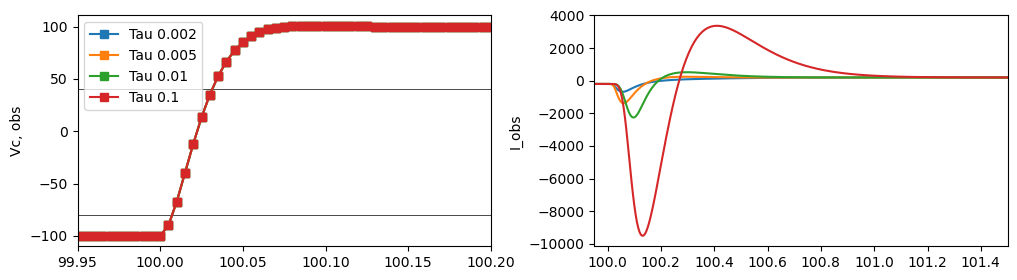

In [5]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, obs')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

ts = [2e-3, 5e-3, 10e-3, 100e-3]  # us
fs = [30, 30, 10, 10]  # kHz

s = s1
tau_name = 'amp.tau_sum'
for tau, fc in zip(ts, fs):
    s.reset()
    s.set_constant('amp.alpha', 0.01)
    s.set_constant('amp.beta', 0)
    s.set_constant(tau_name, tau)
    s.set_constant('amp.f1', fc)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Tau {tau}')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

As shown above, $\tau$ has a considerable influence on the voltage step (in the first half a millisecond!) even though Rs compensation is at 1% and prediction is disabled.

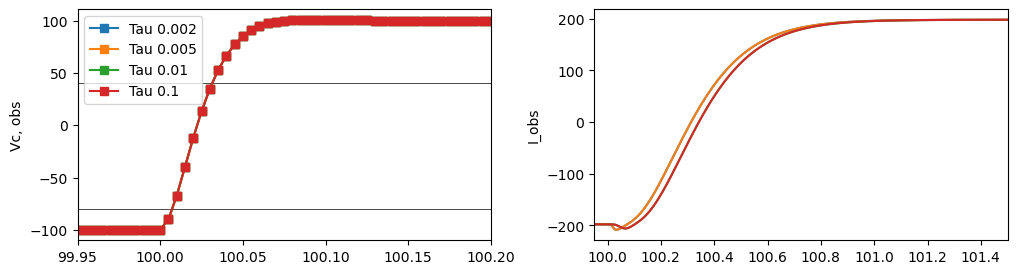

In [6]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, obs')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

s = s2
tau_name = 'amp.tau_rc'
for tau, fc in zip(ts, fs):
    s.reset()
    s.set_constant('amp.alpha', 0.01)
    s.set_constant('amp.beta', 0)
    s.set_constant(tau_name, tau)
    s.set_constant('amp.f1', fc)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Tau {tau}')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

In the model where Rs has a lag but the summing amp does not, we see no effect except for a minor change when switching between filters.
So this experiment can be used to decide if the summing amp or just Rs compensation is slowed by `r_series_tau`.

## Experiment 2a: Vary the stimulus filter

- Disable filter2, set acquisition speed to the highest
- Disable prediction and compensation
- Perform a few simple voltage steps
- Repeat with both settings (20us, 2us)
- TEST: Does our 40us, 4us approximation hold?

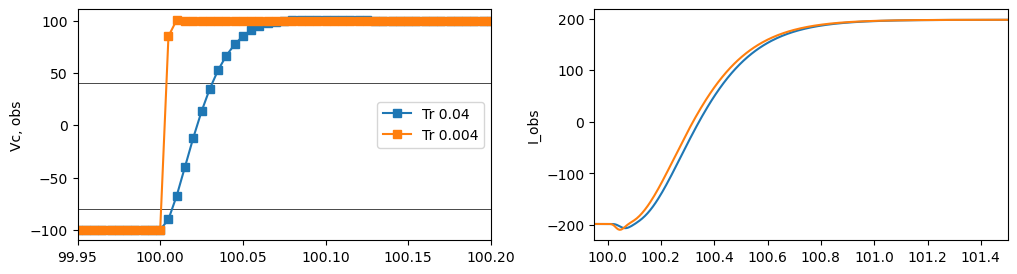

In [7]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, obs')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for tr in [40e-3, 4e-3]:
    s.reset()
    s.set_constant('amp.alpha', 0)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.tr', tr)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Tr {tr}')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

Interesting result here is on the left.

## Experiment 2b: Vary filter1

- Disable filter2, set acquisition speed to the highest [leave stimulus filter at default, see below]
- Disable prediction and compensation
- Perform a few simple voltage steps
- Repeat with four different filter1 settings (Bessel 100, 30, 10, HQ30)
- TEST: Does our model fit these traces well?

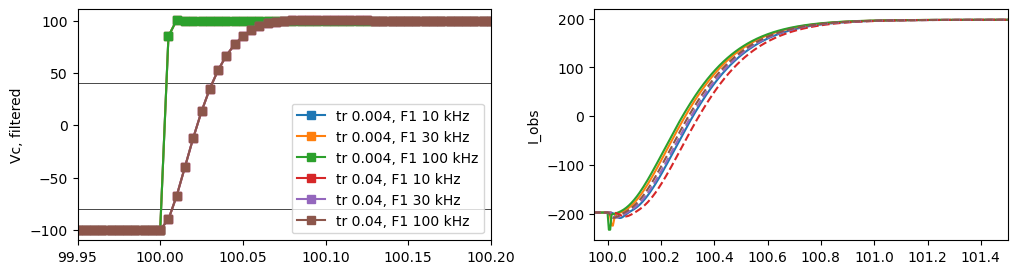

In [8]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, filtered')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for tr in [4e-3, 40e-3]:
    for fc in [10, 30, 100]:
        s.reset()
        s.set_constant('amp.alpha', 0)
        s.set_constant('amp.beta', 0)
        s.set_constant('amp.f1', fc)
        s.set_constant('amp.tr', tr)
        s.set_constant(tau_name, tau)
        d = s.run(200, log_interval=0.005)
        ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'tr {tr}, F1 {fc} kHz')
        ax2.plot(d.time(), d['amp.I_obs'], '--' if tr == 40e-3 else '-')
ax1.legend()
plt.show()

Note: The effects are small (overshadowed by charging time, I guess). But it will be a good test to see if we get _any_ of these right.
Also the general pattern.

## Experiment 2c: Vary filter2

- Set acquisition speed to the highest, set filter1 to 30kHz
- Disable prediction and compensation
- Perform a few simple voltage steps
- Repeat with four different filter2 settings
- TEST: Does our model fit these traces well?

In [9]:
# Model with instantaneous summing, Fs, F1, and a 1-pole Rs comp lag
m3 = myokit.load_model('m-new-2.mmt')
m3.check_units(myokit.UNIT_STRICT)

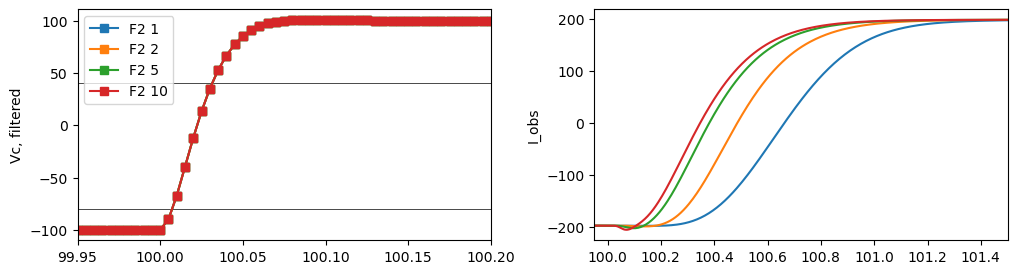

In [10]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, filtered')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

s = myokit.Simulation(m3, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for fc in [1, 2, 5, 10]:
    s.reset()
    s.set_constant('amp.alpha', 0)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.f1', 30)
    s.set_constant('amp.f2', fc)    
    s.set_constant(tau_name, tau)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'F2 {fc}')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

It'd be very pleasing if we could match these (which include Fs, F1, and F2 effects).

## Experiment 2d: Vary Cslow and Cfast estimates

- Set acquisition speed to the highest, disable filter2, set filter1 to 30kHz
- Disable prediction and compensation
- Perform a few simple voltage steps
- Repeat with different Cslow and Cfast settings
- TEST: Does our model fit these traces well?

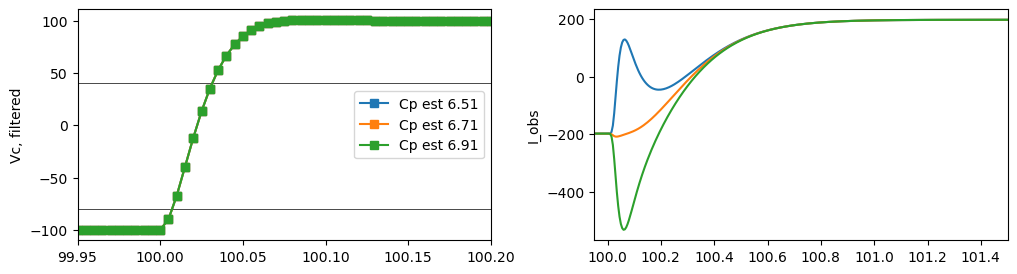

In [14]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, filtered')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for cp in [6.51, 6.71, 6.91]:
    s.reset()
    s.set_constant('amp.alpha', 0)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.f1', 30)
    s.set_constant('amp.Cp_est', cp)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Cp est {cp}')
    ax2.plot(d.time(), d['amp.I_obs'])
s.set_constant('amp.Cp_est', 5.78)
ax1.legend()
plt.show()

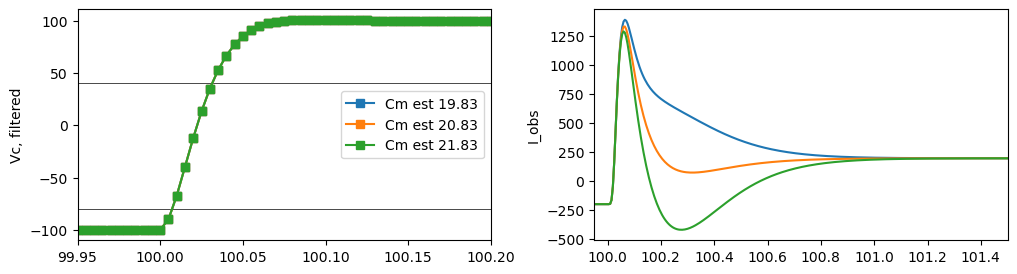

In [15]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, filtered')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')
for cm in [19.83, 20.83, 21.83]:
    s.reset()
    s.set_constant('amp.alpha', 0)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.f1', 30)
    s.set_constant('amp.Cm_est', cm)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Cm est {cm}')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

These should be considerably simpler than ones we record with Rs comp on:

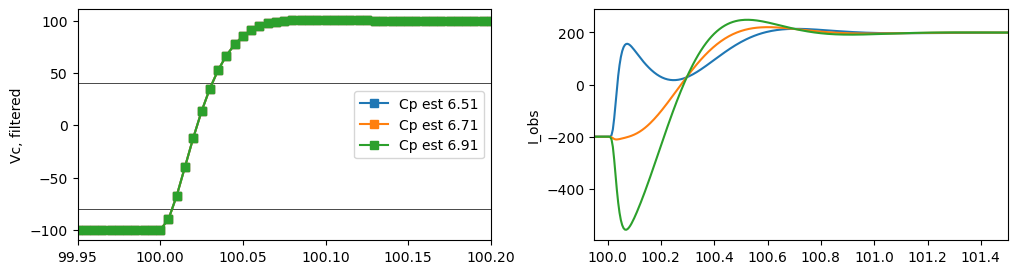

In [17]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, filtered')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for cp in [6.51, 6.71, 6.91]:
    s.reset()
    s.set_constant('amp.alpha', 0.7)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.f1', 30)
    s.set_constant('amp.Cp_est', cp)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Cp est {cp}')
    ax2.plot(d.time(), d['amp.I_obs'])
s.set_constant('amp.Cp_est', 5.78)
ax1.legend()
plt.show()

## Experiment 3a: Vary `r_series_tau`

- Set acquisition speed to the highest, disable filter2, let filter1 be set by software
- Set compensation and prediction to 70% and 0%
- Perform a few simple voltage steps
- Repeat with different `r_series_tau` settings
- Then repeat with prediction at 70%
- TEST: Does our model fit these traces well?

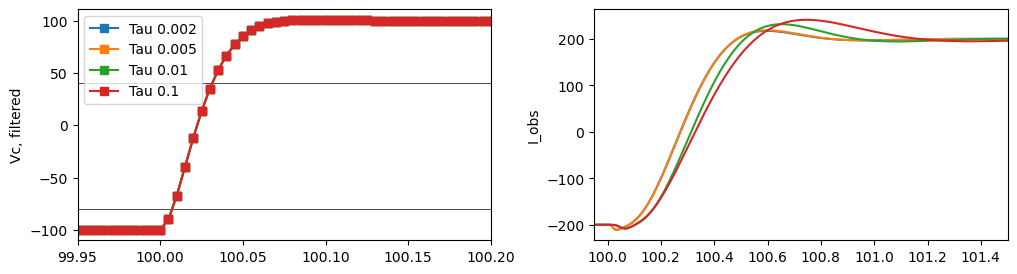

In [18]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, filtered')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

ts = [2e-3, 5e-3, 10e-3, 100e-3]  # us
fs = [30, 30, 10, 10]  # kHz

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for tau, fc in zip(ts, fs):
    s.reset()
    s.set_constant('amp.alpha', 0.7)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.f1', fc)
    s.set_constant('amp.tau_rc', tau)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Tau {tau}')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

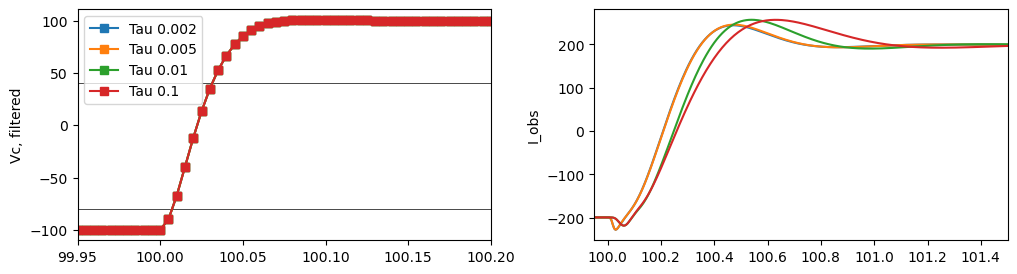

In [19]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, filtered')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

ts = [2e-3, 5e-3, 10e-3, 100e-3]  # us
fs = [30, 30, 10, 10]  # kHz

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for tau, fc in zip(ts, fs):
    s.reset()
    s.set_constant('amp.alpha', 0.7)
    s.set_constant('amp.beta', 0.7)
    s.set_constant('amp.f1', fc)
    s.set_constant('amp.tau_rc', tau)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Tau {tau}')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

# Summary

https://docs.google.com/document/d/16gZhGwASRwdQxSwyyBSN89Eq2uGS2XQD4JRMZGx0qqk/edit?usp=sharing

## Gary's idea

Would it be easier to have the model cell in a mode without Cm?

The model cell: https://www.heka.com/products/products_main.html#physiol_mc10